In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
# import warnings
# warnings.filterwarnings("ignore")

In [2]:
df_chunk = pd.read_csv('train.csv', chunksize = 1000000, low_memory = False)
# chunk_list = []
count = 0
chunks = []
for chunk in df_chunk:
    #print(chunk.head(25))
#     print(chunk.describe())
#     print(chunk.isnull().sum())
    chunks.append(pd.DataFrame(chunk))
    count += 1
    break
# print(count)
# df_concat = pd.concat(chunk_list)
print(chunks[0].head())

                             key  fare_amount          pickup_datetime  \
0    2010-10-20 23:26:26.0000003          4.5  2010-10-20 23:26:26 UTC   
1   2009-12-30 10:56:00.00000075          4.1  2009-12-30 10:56:00 UTC   
2   2012-07-20 11:24:00.00000022          6.1  2012-07-20 11:24:00 UTC   
3  2011-05-31 11:29:00.000000136          4.9  2011-05-31 11:29:00 UTC   
4  2010-05-25 17:57:00.000000145          6.5  2010-05-25 17:57:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.986910        40.739538         -73.991381         40.745614   
1        -73.961572        40.760283         -73.957438         40.769387   
2        -73.979437        40.746517         -73.984195         40.732117   
3        -73.964097        40.792508         -73.976422         40.785767   
4        -74.003943        40.725670         -73.988915         40.748370   

   passenger_count  
0                2  
1                5  
2                1  
3       

In [3]:
print(chunks[0].describe())



          fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  1000000.000000    1000000.000000   1000000.000000      999991.000000   
mean        11.343352        -72.521310        39.925188         -72.518306   
std          9.807783         13.036747         7.901750          13.401471   
min        -62.000000      -3007.205450     -3458.664702       -3383.296608   
25%          6.000000        -73.992092        40.734898         -73.991392   
50%          8.500000        -73.981823        40.752657         -73.980150   
75%         12.500000        -73.967111        40.767103         -73.963687   
max        495.000000       2434.238557      2009.266280        3382.125693   

       dropoff_latitude  passenger_count  
count     999991.000000   1000000.000000  
mean          39.925168         1.683403  
std           11.382385         1.306486  
min        -3461.540872         0.000000  
25%           40.734000         1.000000  
50%           40.753122       

In [4]:
print(chunks[0].isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    9
dropoff_latitude     9
passenger_count      0
dtype: int64


In [25]:
coord_list = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

# temp = pd.DataFrame(chunks[0])
# temp.dropna(inplace = True)
chunks[0].dropna(inplace = True)
print("chunks[0]:")
print(chunks[0].isnull().sum())
# print("temp:")
# print(temp.isnull().sum())


chunks[0]:
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


AxesSubplot(0.125,0.125;0.775x0.755)


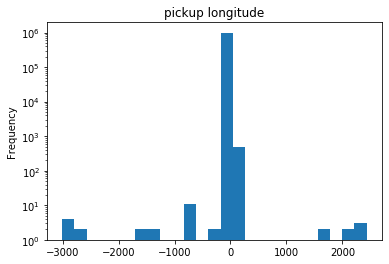

In [6]:
fig, ax = plt.subplots()
print(chunks[0]["pickup_longitude"].plot.hist(ax = ax, title="pickup longitude",bottom=1, bins=25))
ax.set_yscale('log')
# plot1 = chunks[0]['pickup_longitude']
# plot1.plot.hist(grid=True, bins=1, rwidth=0.9, color='#607c8e')
# plt.xlabel('Pregnancies')
# plt.grid(axis='y')

AxesSubplot(0.125,0.125;0.775x0.755)


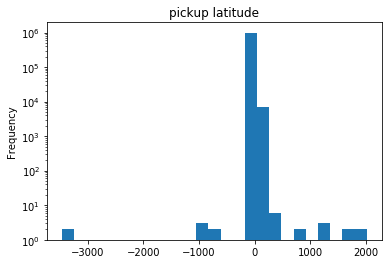

In [7]:
fig, ax = plt.subplots()
print(chunks[0]["pickup_latitude"].plot.hist(ax = ax, title="pickup latitude",bottom=1, bins=25))
ax.set_yscale('log')

AxesSubplot(0.125,0.125;0.775x0.755)


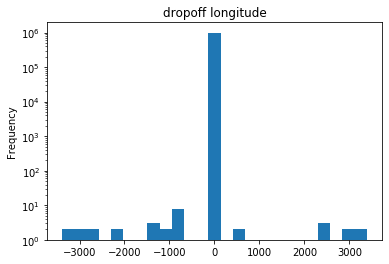

In [8]:
fig, ax = plt.subplots()
print(chunks[0]["dropoff_longitude"].plot.hist(ax = ax, title="dropoff longitude",bottom=1, bins=25))
ax.set_yscale('log')

AxesSubplot(0.125,0.125;0.775x0.755)


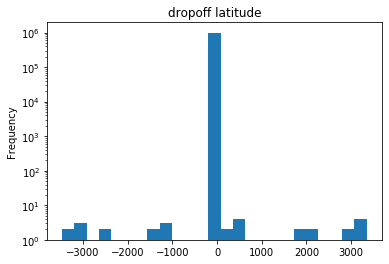

In [9]:
fig, ax = plt.subplots()
print(chunks[0]["dropoff_latitude"].plot.hist(ax = ax, title="dropoff latitude",bottom=1, bins=25))
ax.set_yscale('log')

AxesSubplot(0.125,0.125;0.775x0.755)


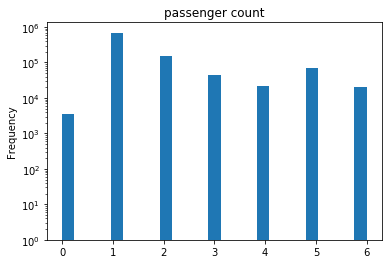

In [10]:
fig, ax = plt.subplots()
print(chunks[0]["passenger_count"].plot.hist(ax = ax, title="passenger count",bottom=1, bins=25))
ax.set_yscale('log')

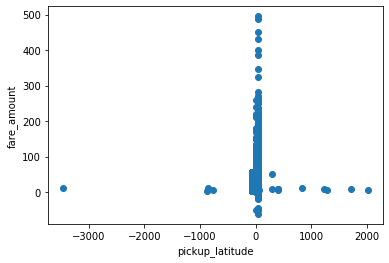

In [11]:
plt.scatter(chunks[0]["pickup_latitude"],chunks[0]["fare_amount"])
plt.xlabel("pickup_latitude")
plt.ylabel("fare_amount")
plt.show()

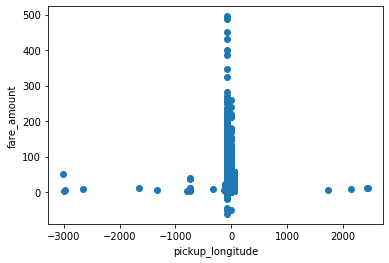

In [12]:
# fig, ax = plt.subplots()

plt.scatter(chunks[0]["pickup_longitude"],chunks[0]["fare_amount"])
plt.xlabel("pickup_longitude")
plt.ylabel("fare_amount")
plt.show()

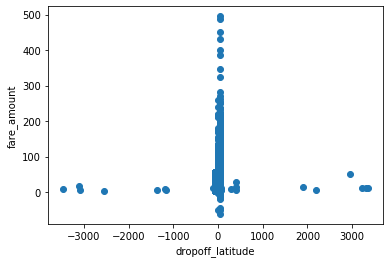

In [13]:
plt.scatter(chunks[0]["dropoff_latitude"],chunks[0]["fare_amount"])
plt.xlabel("dropoff_latitude")
plt.ylabel("fare_amount")
plt.show()

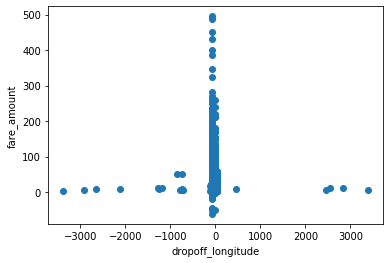

In [14]:
plt.scatter(chunks[0]["dropoff_longitude"],chunks[0]["fare_amount"])
plt.xlabel("dropoff_longitude")
plt.ylabel("fare_amount")
plt.show()

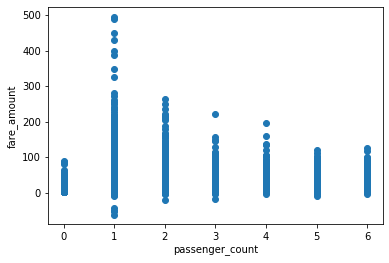

In [15]:
plt.scatter(chunks[0]["passenger_count"],chunks[0]["fare_amount"])
plt.xlabel("passenger_count")
plt.ylabel("fare_amount")
plt.show()

In [23]:
for c in coord_list:
    for i in range(len(chunks[0][c])):
        if(c == 'pickup_longitude' or c == 'dropoff_longitude'):
            if(chunks[0][c][i] > 180 or chunks[0][c][i] < -180):
                chunks[0].drop(chunks[0].index[i])
        else:
            if(chunks[0][c][i] > 90 or chunks[0][c][i] < -90):
                chunks[0].drop(chunks[0].index[i])

KeyError: 161652

In [24]:
len(chunks[0]['pickup_longitude'])

999991